# **Homework 5 Practicum**
# Version 1.0 (Nov 15, 2024)

<font color='blue'> TODO:</font> Trevor Black (tblack20)

Instructions:
This notebook has two parts:

Part 1: Implement Principal Component Analysis (PCA) and K-Nearest Neghbors (KNN)

Part 2: Implement Q Learning algorithm.

Please note that in this practicum, we only require code implementation without any usual questions.

Please <font color='blue'>make a copy of this notebook in your own drive</font> before you make any edits. You can do so through File -> Save a copy in Drive

NOTE: Submit notebook on gradescope. You can run autograder as many times as needed.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs,make_classification,load_wine,load_iris,load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA as SKLearnPCA
from collections import Counter
from sklearn.preprocessing import StandardScaler
import random

random.seed(42)
np.random.seed(42)




# **PART I: Implement Principal Component Analysis (PCA) and K-Nearest Neghbors (KNN)**

Principal Component Analysis (PCA) is a widely used technique in machine learning for dimensionality reduction. It aims to reduce the number of variables (features) in a dataset while preserving as much of the original information as possible.

PCA identifies the "directions" (called principal components) along which the data varies the most. These components are ordered by the amount of variance they explain in the dataset.This helps in visualizing data, improving model accuracy, and reducing overfitting.
In this implementation, we will create our own custom PCA class, compare its performance with the PCA implementation from scikit-learn, and demonstrate its use in a classification task. This will help us understand the trade-offs between using PCA and working with the original, high-dimensional data.

K-Nearest Neighbors (KNN) is a simple and intuitive supervised machine learning algorithm used for both classification and regression tasks. It works by classifying a data point based on the majority class (for classification) of its K closest neighbors in the feature space, where distance between points is typically measured using Euclidean distance.
KNN is a lazy learner, meaning it doesn't build an explicit model during training, but instead uses the entire training dataset to make predictions at runtime. While KNN is easy to implement and doesn't require a lot of training, it can be computationally expensive, especially with large datasets, and is sensitive to the choice of K and irrelevant features. Feature scaling is important to improve its performance, and the algorithm may struggle with high-dimensional data due to the "curse of dimensionality." Hence, we will compare the performance of KNN with and without PCA.

Things todo:

1. Implement fit_transform and transform methods of MyPCA class.
2. Implement predict method of KNN class




In [2]:
#DONOT MODIFY
def generate_synthetic_data(num_samples=1000, num_features=100, num_classes=2):
    """
    Generate synthetic data using make_classification function.

    Parameters:
    - n_samples (int): Number of samples to generate.
    - n_features (int): Number of features for each sample.
    - centers (int): Number of centers for blobs.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - X (ndarray): The generated synthetic data.
    - y (ndarray): The labels (not needed for PCA, but useful for classification tasks).
    """

    X,y = make_classification(n_samples=num_samples, n_features=num_features, n_informative=20, n_classes=num_classes, random_state=42)
    return X, y

In [14]:

class MyPCA:
    """
    A custom PCA implementation for dimensionality reduction.
    """

    def __init__(self, n_components=None):
        """
        Initialize the PCA object.

        Parameters:
        - n_components (int or None): Number of components to keep. If None, all components are kept.
        """
        self.n_components = n_components
        self.mu = None  # Mean of the data
        self.V_m = None  # Matrix of principal components
        self.sorted_eigenvalues = None  # Sorted eigenvalues

    def fit_transform(self, D):
        """
        Perform PCA on the dataset and return the transformed data.

        Parameters:
        - D (ndarray): The input data (n_samples x n_features).

        Returns:
        - D_tilde (ndarray): The transformed dataset (n_samples x n_components).
        """
        
        # steps outlined on slide 15.5

        # step 1, estimate mean vectors
        self.mu = np.mean(D, axis=0) # take mean on rows

        # step 2, zero-center data
        zeroed = D - self.mu

        # step 3, calculate empirical covariance matrix
        Cov = 1/(D.size - 1) * zeroed.transpose() @ zeroed

        # step 4, compute eigendecomposition of covariance matrix
        eigen_vals, eigen_vecs = np.linalg.eigh(Cov)

        # step 5, sort eigen matrices
        sorted_indices = np.argsort(eigen_vals)
        self.sorted_eigenvalues = eigen_vals[sorted_indices]
        V = eigen_vecs[sorted_indices]

        # step 6, pick m < k largest eigenvalues
        self.V_m = V[:, :self.n_components]

        # step 7, project centered data
        D_tilde = zeroed @ self.V_m

        return D_tilde

    def transform(self, D):
        """
        Transform the data using the fitted PCA model.

        Parameters:
        - D (ndarray): The input data (n_samples x n_features).

        Returns:
        - D_tilde (ndarray): The transformed dataset (n_samples x n_components).
        """
        zeroed = D - self.mu
        D_tilde = zeroed @ self.V_m
        return D_tilde

    def explained_variance(self):
        """
        Calculate the explained variance ratio for the selected principal components.

        The total variance is the sum of the eigenvalues of all the principal components.
        This represents the overall spread of the data in the original feature space.

        The explained variance is the sum of the eigenvalues corresponding to the top n_components principal components.
        This represents the spread of the data along the selected components.

        Hence, the ratio gives us an idea of how much of the original data's variance is retained by the selected components.
        Returns:
        - explained_variance (float): The proportion of variance explained by the selected components.
        """
        total_variance = np.sum(self.sorted_eigenvalues)
        explained_variance = np.sum(self.sorted_eigenvalues[:self.n_components])
        return explained_variance / total_variance


In [15]:
#DONOT MODIFY

def compare_pca(num_components):
    """
    Compare the explained variance of MyPCA and sklearn PCA on synthetic dataset.

    Parameters:
    - X (ndarray): The input data (n_samples x n_features).
    """
    X = generate_synthetic_data(num_samples=1000, num_features=100, num_classes=2)[0]
    # Standardize the dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply your PCA (MyPCA)
    my_pca = MyPCA(n_components=num_components)
    X_pca = my_pca.fit_transform(X_scaled)

    # Print MyPCA explained variance
    print(f"MyPCA Explained Variance: {my_pca.explained_variance():.4f}")

    # Apply sklearn PCA
    sklearn_pca = SKLearnPCA(n_components=num_components)
    X_pca_sklearn = sklearn_pca.fit_transform(X_scaled)

    # Print sklearn PCA explained variance
    print(f"sklearn PCA Explained Variance: {np.sum(sklearn_pca.explained_variance_ratio_):.4f}")
    return my_pca.explained_variance(), np.sum(sklearn_pca.explained_variance_ratio_)

_,_ = compare_pca(20)

MyPCA Explained Variance: 0.0935
sklearn PCA Explained Variance: 0.3301


In [ ]:


class KNN:
    def __init__(self, k=5):
        """
        KNN classifier initialization.

        :param k: Number of neighbors to consider when making a prediction
        """
        self.k = k

    def fit(self, X_train, y_train):
        """
        Store training data.

        :param X_train: Training data features (2D numpy array)
        :param y_train: Training data labels (1D numpy array)
        """
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        """
        Predict the label for each test point in X_test.

        :param X_test: Test data features (2D numpy array)
        :return: Predicted labels (1D numpy array)
        """
        predictions = [self._predict(x) for x in X_test]
        return np.array(predictions)

    def _predict(self, x):
        """
        Predict the label for a single test point.

        :param x: Single test data point (1D numpy array)
        :return: Predicted label (scalar)
        """
        # get distances of x to each X in training data
        distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]

        # get k nearest neighbors
        k_nearest_indices = np.argsort(distances)[:self.k]

        # get corresponding labels
        labels = self.y_train[k_nearest_indices]

        # get most common label
        c = Counter(labels)
        return c.most_common(1)[0][0] # first most common, first element (gets the value, excludes # occurences)

    def _euclidean_distance(self, x1, x2):
        """
        Compute the Euclidean distance between two points.

        :param x1: First point (1D numpy array)
        :param x2: Second point (1D numpy array)
        :return: Euclidean distance (float)
        """
        return np.sqrt(np.sum((x1 - x2) ** 2))




In [22]:

#DONOT MODIFY; Note: On colab it took 4-5min to run
def classification_with_pca():
    """
    Use PCA for dimensionality reduction in classification task using KNN.
    """
    # Step 1: Generate the synthetic data
    X , y = generate_synthetic_data(num_samples=5000, num_features=200, num_classes=2)
    # Step 2: Split the data into training and testing sets
    print(f"Data shape ={X.shape}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Step 3: Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Step 4: Apply KNN without PCA and evaluate the performance
    knn = KNN()
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy_before_pca = accuracy_score(y_test, y_pred)
    print(f"Accuracy before PCA: {accuracy_before_pca:.4f}")
    # Step 5: Apply KNN with PCA and evaluate the performance
    pca = MyPCA(n_components=20)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    knn_pca = KNN()
    knn_pca.fit(X_train_pca, y_train)
    y_pred_pca = knn_pca.predict(X_test_pca)
    accuracy_after_pca = accuracy_score(y_test, y_pred_pca)
    print(f"Accuracy after PCA(5 components): {accuracy_after_pca:.4f}")




classification_with_pca()


Data shape =(5000, 200)
Accuracy before PCA: 0.6940
Accuracy after PCA(5 components): 0.5893


# **PART II: Reinforcement learning**

Q-learning is a model-free reinforcement learning algorithm used to find the optimal action-selection policy for any given Markov decision process (MDP). It works by learning an action-value function that gives the expected utility of taking a particular action in a particular state and following the optimal policy thereafter

We will solve a control problem in this excercise (Balance Cartpole). The goal is to balance a pole on a cart by moving the cart left or right. The state space consists of the cart's position, velocity, pole angle, and pole angular velocity. The agent can take two actions: move the cart left or right. The agent receives a reward of +1 for each time step the pole is balanced, and the episode ends when the pole falls beyond a certain angle or the cart moves out of bounds.

More information about the cartpole environment can be found here: https://gymnasium.farama.org/environments/classic_control/cart_pole/


Since the state in this problem is continuous, we will discretize the state space using a grid; see `get_discrete_state` function.

Things to do in this part:
1. Understand the interaction flow of the gym environment. A simple usage can be found in the main page of the gym library: https://gymnasium.farama.org/

2. Your main task is to implement the `train_qlearning` function. You have the flexibility to implement the Q-learning algorithm as you see fit, as long as it functions correctly. The evaluation will be based on the total reward obtained using your qTable. Refer to `evaluation_qlearning` for details.

We also provide the `save_to_gif` function to view how your q learning perform in the simulation


The gradescope test case will be based on `evaluation_qlearning`. You will pass if the **average total reward** exceeds the required threshold.



Use the following command to install the required packages.

In [ ]:
!pip install gymnasium imageio

In [23]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [24]:
env = gym.make('CartPole-v1')
state, _ = env.reset()
print(state) # state is a real vector.

[-0.00448892 -0.03126102  0.02695922  0.04819566]


In [25]:
# Do not change this cell
STATE_SIZE = 4
NUM_BIN = 20
# Get the size of each bucket
bins = [
	np.linspace(-4.8, 4.8, NUM_BIN),
	np.linspace(-4, 4, NUM_BIN),
	np.linspace(-.418, .418, NUM_BIN),
	np.linspace(-4, 4, NUM_BIN)
]
# Given a state of the environment, return its discreteState index in qTable
def get_discrete_state(state):
    stateIndex = []
    for i in range(STATE_SIZE):
        stateIndex.append(np.digitize(state[i], bins[i]) - 1)  # -1 will turn bin into index

    bin_number = 0
    for i, v in enumerate(stateIndex):
        bin_number += v * NUM_BIN**i
    return bin_number

In [46]:
# This is just a suggestion template, you're free to implement
# this function however you want, do not change the function signature,
# it will failed the autograder.
def train_qlearning(env, episodes=1000):
	qTable = np.random.uniform(low=-2, high=0, size=([NUM_BIN ** STATE_SIZE ] + [2])) # random initialize table
	# Define some constants that you want to use
	LEARNING_RATE = 0.1
	DISCOUNT = 0.95
	reward_per_episode = [] # for keep track of the reward

	# model free -> epsilon greedy
	epsilon = 1.0

	for i_episode in range(episodes):
		state, _ = env.reset()
		state = get_discrete_state(state) # convert continuous state to discrete state
		done = False  # has the enviroment finished?
		reward_episode = 0  # how may movements cart has made

		while not done:
			# your epsilon greedy policy

			if np.random.random() < epsilon: # explore
				action = env.action_space.sample()
			else: # exploit
				action = np.argmax(qTable[state])

			next_state, reward, done, _, _ = env.step(action)  # perform action
			reward_episode += reward # keep track of the total reward of this episode
			# Update Q table

			next_state = get_discrete_state(next_state)

			max_future_q = np.max(qTable[next_state])
			current_q = qTable[state][action]

			# eq based on slide 16.12
			qTable[state][action] = current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q - current_q)

			state = next_state

		reward_per_episode.append(reward_episode)

		# explore less in future episodes
		if epsilon > .01:
			epsilon *= .99

		# Add new metrics for graph
		if i_episode % 100 == 0:
			latest_runs = reward_per_episode[-100:]
			average_reward = sum(latest_runs) / len(latest_runs)
			print(f"Episode {i_episode}, Average Reward: {average_reward}")

	env.close()

	return qTable


In [47]:
# We use this function to test on gradescope, don't change it
def evaluate_qlearning(qTable, env, episodes=100):
    scores = []
    for _ in range(episodes):
        state, _ = env.reset()
        discreteState = get_discrete_state(state)
        done = False
        score = 0
        while not done:
            action = np.argmax(qTable[discreteState])
            state, reward, done, _, _ = env.step(action)
            discreteState = get_discrete_state(state)
            score += reward
        scores.append(score)
    return scores

In [50]:
# #Uncomment to test your qlearning implementation
env = gym.make('CartPole-v1')
qTable = train_qlearning(env, episodes=3000)
assert np.mean(evaluate_qlearning(qTable, env)) > 30 # you should see the average reward increasing.

Episode 0, Average Reward: 15.0
Episode 100, Average Reward: 25.67
Episode 200, Average Reward: 42.32
Episode 300, Average Reward: 47.02
Episode 400, Average Reward: 49.61
Episode 500, Average Reward: 47.98
Episode 600, Average Reward: 67.0
Episode 700, Average Reward: 70.11
Episode 800, Average Reward: 69.51
Episode 900, Average Reward: 72.83
Episode 1000, Average Reward: 67.5
Episode 1100, Average Reward: 73.62
Episode 1200, Average Reward: 72.26
Episode 1300, Average Reward: 68.94
Episode 1400, Average Reward: 66.31
Episode 1500, Average Reward: 63.77
Episode 1600, Average Reward: 67.62
Episode 1700, Average Reward: 62.97
Episode 1800, Average Reward: 59.36
Episode 1900, Average Reward: 62.99
Episode 2000, Average Reward: 61.3
Episode 2100, Average Reward: 62.75
Episode 2200, Average Reward: 63.58
Episode 2300, Average Reward: 61.38
Episode 2400, Average Reward: 63.42
Episode 2500, Average Reward: 67.48
Episode 2600, Average Reward: 63.75
Episode 2700, Average Reward: 66.25
Episode 

In [41]:
from matplotlib import animation
import matplotlib.pyplot as plt
import imageio
from tqdm import trange
from IPython.display import Image

def save_to_gif(filename, qTable):
    #Make gym env
    env = gym.make('CartPole-v1', render_mode="rgb_array")

    #Run the env
    state, _ = env.reset()
    frames = []
    for t in trange(200):
        #Render to frames buffer
        frames.append(env.render())
        action = qTable[get_discrete_state(state)].argmax()
        state, _, done, _, _ = env.step(action)
        if done:
            break
    env.close()
    imageio.mimsave(filename, frames, duration=0.04)

 28%|██▊       | 55/200 [00:00<00:02, 58.48it/s]


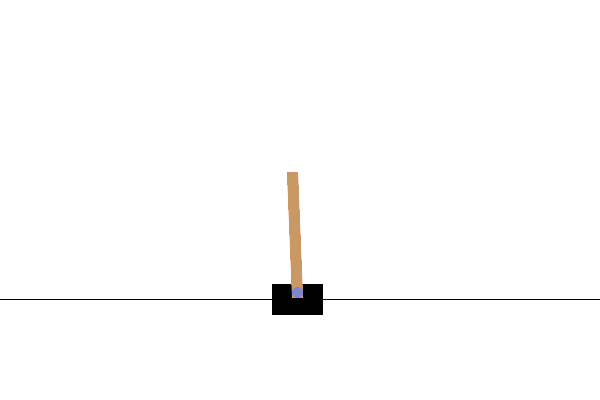

In [51]:
# #Uncomment to view the gif
save_to_gif('record.gif', qTable)
Image(open('record.gif','rb').read())

## Feedback

Please provide us with some feedback on how long each section or this homework overall took you. Any other feedback is also welcomed.

## Submit
Great work! You're all done.

Make sure to submit this Python notebook. See the homework writeup for directions.